In [41]:
import skrf as rf
from skrf.constants import K_BOLTZMANN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
from devices.devices_lib import make_cavity__with_antennas_network # From Chirstan Boutan's PNNL team
import components as cmp # From Jihee
import os.path

%matplotlib inline

In [18]:
freq = rf.frequency.Frequency(start=1, stop=3, npoints=1001, unit='ghz', sweep_type='lin')

In [19]:
###############################
##### Component Functions   ###
###############################
#(From Jihee's components.py and analyis_run1C_tsys.py)


### Function to read network in noisy environment ###
def read_in_noisy_network(ntw,freq_interp,Tphys):
    ntw_interp = ntw.interpolate(freq_interp, kind='cubic')
    ntw_interp_noisy = rf.NoisyNetwork(ntw_interp)
    ntw_interp_noisy.noise_source(source='passive',T0 = Tphys)

    return ntw_interp_noisy

In [20]:
# Why is noise power negative for the amplifier??

In [32]:
def make_amplifier(freq,G):
    db_to_amp = lambda x: 10**(x/20)            
    
    RL_1 = 15.0 # values from datasheet at 2Ghz
    RL_2 = 11.0
    isolation_db = 21 #mouser.com, ZX60-83LN-S+

    A = db_to_amp(G) 
    reflection_1 = db_to_amp(-RL_1)
    reflection_2 = db_to_amp(-RL_2) 
    isolation = db_to_amp(-isolation_db)  

    s = np.zeros((len(freq), 2, 2))

    s[:,0,0] = reflection_1
    s[:,0,1] = isolation
    s[:,1,0] = A
    s[:,1,1] = reflection_2
    
    return rf.Network(frequency=freq,s=s)

/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


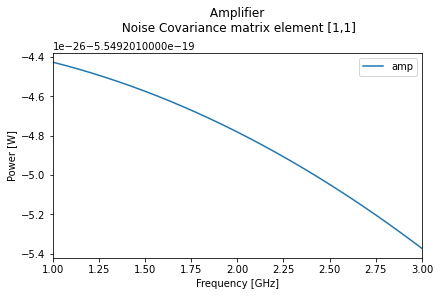

In [33]:
Troom = 300 #K
amplifier = make_amplifier(freq, 21.3) #G = 21.3 #db, Vdd = 5.0 V, typ at 2Ghz.
noisy_amp = read_in_noisy_network(amplifier,freq,Troom)

plt.plot(freq.f/1e9,noisy_amp.cs[:,1,1],label='amp')

plt.xlim(1,3)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Power [W]')
plt.title(f' Amplifier \n Noise Covariance matrix element [1,1]\n')
plt.legend()
plt.tight_layout(pad=0.3, w_pad=0.2, h_pad=0.2)

# Code from Jihee

In [64]:
def gen_ZX60_83LN_S_NF_func(ZX60_83LN_NF_loc):
    noise_figure_data2 = pd.read_csv(ZX60_83LN_NF_loc , header = None, encoding='unicode_escape')
    noise_figure_data2[11] = 10**(noise_figure_data2[10]/10)
    NF_Func2 = interp1d(noise_figure_data2[0],noise_figure_data2[11],fill_value=1000)
    
    return NF_Func2

def return_ZX60_83LN_params(Amp_path,Amp_name,freq,sat_check=False,vendor=True,Temp=290):
    
    # ZX60_83LN_fpath = r'.\raw data\raw data'
    # ZX60_83LN_noise_figure_fnmae = r'ZX60_83LN_NF.csv'
    # ZX60_83LN_NF_loc = os.path.join(ZX60_83LN_fpath, ZX60_83LN_noise_figure_fname)
    ZX60_83LN_NF_loc = r'/Users/zacharybanken/Desktop/research_stuff/Terminator Temp Test/amplifier_data/ZX60_83LN_NF.csv'
    
    Tphys = Temp
    
    Amp_loc = os.path.join(Amp_path,Amp_name)
    amp_sparam = rf.Network(Amp_loc)
    amp_sparam = amp_sparam.interpolate(freq,kind='cubic')
    amp_sparam  = rf.NoisyNetwork(amp_sparam)
    amp_sparam.noise_source(source='passive',T0=Tphys)
    
    try:
        NF_func = gen_ZX60_83LN_S_NF_func(ZX60_83LN_NF_Loc)
        nfig = NF_func(freq.f/1e9)
    except:
        print('error')
        
    Tnoise = rf.NetworkNoiseCov.Tnoise(freq.f,Tphys)
    
    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I,np.conjugate(amp_sparam.s.swapaxes(1,2)))
    SAS = np.matmul(amp_sparam.s,AS)
    
    amp_sparam.cs[:,0,0] = (nfig - 1) * K_BOLTZMANN * 290 * SAS[:,0,0]
    
    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I,np.conjugate(amp_sparam.s.swapaxes(1,2)))
    SAS = np.matmul(amp_sparam.s,AS)
    
    amp_sparam.cs[:,1,1] = (nfig-1) * K_BOLTZMANN * 290 * SAS[:,1,1]
    
    amp_sparam.cs[:,0,1] = np.zeros_like(amp_sparam.cs[:,1,1])
    amp_sparam.cs[:,1,0] = amp_sparam.cs[:,0,1]
    
    return amp_sparam
    

In [65]:
amp_path = r'/Users/zacharybanken/Desktop/research_stuff/Terminator Temp Test/amplifier_data'
amp_name = r'ZX60-83LN-S+_AP160503_060216_RF PARAM_Unit2.s2p'

return_ZX60_83LN_params(amp_path,amp_name,freq)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 127: invalid start byte

In [69]:
amp_sparam = rf.Network(r'/Users/zacharybanken/Desktop/research_stuff/Terminator Temp Test/amplifier_data/ZX60-83LN-S+_AP160503_060216_RF PARAM_Unit2.s2p')







UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 127: invalid start byte

In [74]:
cav = rf.Network('/Users/zacharybanken/Desktop/research_stuff/Terminator\ Temp\ Test/amplifier_data/ZX60-83LN-S+_AP160503_060216_RF PARAM_Unit2.s2p')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 127: invalid start byte